# Initialization

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import string
import os
import re

In [140]:
def init_val():
    return (np.random.random() * 0.1) - 0.05 + 0.5

In [141]:
# A very useful function to normalize a dictionary of floats
def normalize(d):
    total = 0
    for k in d:
        total += d[k]
    for k in d:
        d[k] /= total
        
    return d

# Language Detecting (Lab 7)

In [142]:
import codecs
langs = {"candide.txt":"French", "quijote.txt":"Spanish", "zarathustra.txt":"German", "wonderland.txt":"English"}

chars = []
for b in langs:
    fin = codecs.open("Books/" + b, "r", "utf-8")
    for line in fin:
        for c in line.lower().strip():
            if c not in chars and c not in string.punctuation and c not in string.digits and c not in '¡«°»¿':
                chars.append(c)
    fin.close()
    
chars.sort()
chars[0] = u" "
chars.pop()
print("".join(chars))

 abcdefghijklmnopqrstuvwxyzßàáâäçèéêëíîïñóôöùúû


In [5]:
class MarkovChain:
    
    def __init__(self, filename, chars, language):
        self.language = language
        self.chars = chars
        self.create(filename)
        
    def create(self, filename):
        self.a = {}
        
        #############
        # WRITE CODE HERE
        #############
        
        # Initialize all pathways with a pseduocount of 1
        for i in self.chars:
            temp = {}
            for j in self.chars:
                temp[j] = 1
            self.a[i] = temp
        
        # Record all the transitions in the given file for valid characters
        lines = []
        fopen = codecs.open("Books/" + filename, "r", "utf-8")
        for line in fopen:
            line = line.lower()
            line = line.translate({ord(c): None for c in string.punctuation or c in string.digits or c in '¡«°»¿'})
            line = line.replace('/r', '')

            #Need to lower all letters and strip punctuation
            for i in range(len(line) - 1):
                try: 
                    self.a[line[i]][line[i+1]] += 1
                except:
                    pass
        total = 0
        # Normalize the counts to be probabilities for each state
        for i in self.a.keys():
            self.a[i] = normalize(self.a[i])
#             total += sum(self.a[i].values())
            
#         for i in self.a.keys():
#             for j in self.a[i].keys():
#                 self.a[i][j] /= total
#         normalize doesn't return anything
                
            
    def probability(self, phrase):
        p = 1
        
        #############
        # WRITE CODE HERE
        #############
        l = phrase.lower()
        # Multiply the probabilities for each pair of characters in the given phrase
        for i in range(len(phrase) - 1):
            prob = self.a[l[i]][l[i+1]]
            p *= prob
        #might need to find the prob for last letter and space after?

        return p

In [6]:
models = []
for b in langs:
    models.append(MarkovChain(b, chars, langs[b]))

In [7]:
def language_probs(phrase, models):
    probs = {}
    for m in models:
        probs[m.language] = m.probability(phrase)
    normalize(probs)
    return probs

In [8]:
print(u" Dónde está el baño".lower())

 dónde está el baño


### A simple test

In [9]:
t = u"Dónde está el baño"
probs = language_probs(t, models)

In [10]:
probs

{'English': 4.860048557789931e-13,
 'French': 3.423308047974514e-11,
 'German': 1.118716055264969e-12,
 'Spanish': 0.9999999999641622}

### The full test for all phrases

In [11]:
t = [u"Where is the bathroom",
u"Dónde está el baño",
u"Wo ist die Toilette",
u"Où se trouvent les toilettes",
u"Kie estas la necesejo",
u"Kde je toaleta",
u"My hovercraft is full of eels",
u"A légpárnás hajóm tele van angolnákkal",
u"Puno ng palos ang aking hoberkrap",
u"Gari langu linaloangama limejaa na mikunga",
u"Mi aerodeslizador está lleno de anguilas",
u"Mae fy hofrenfad yn llawn llyswennod",
u"Mein Luftkissenfahrzeug ist voller Aale"]

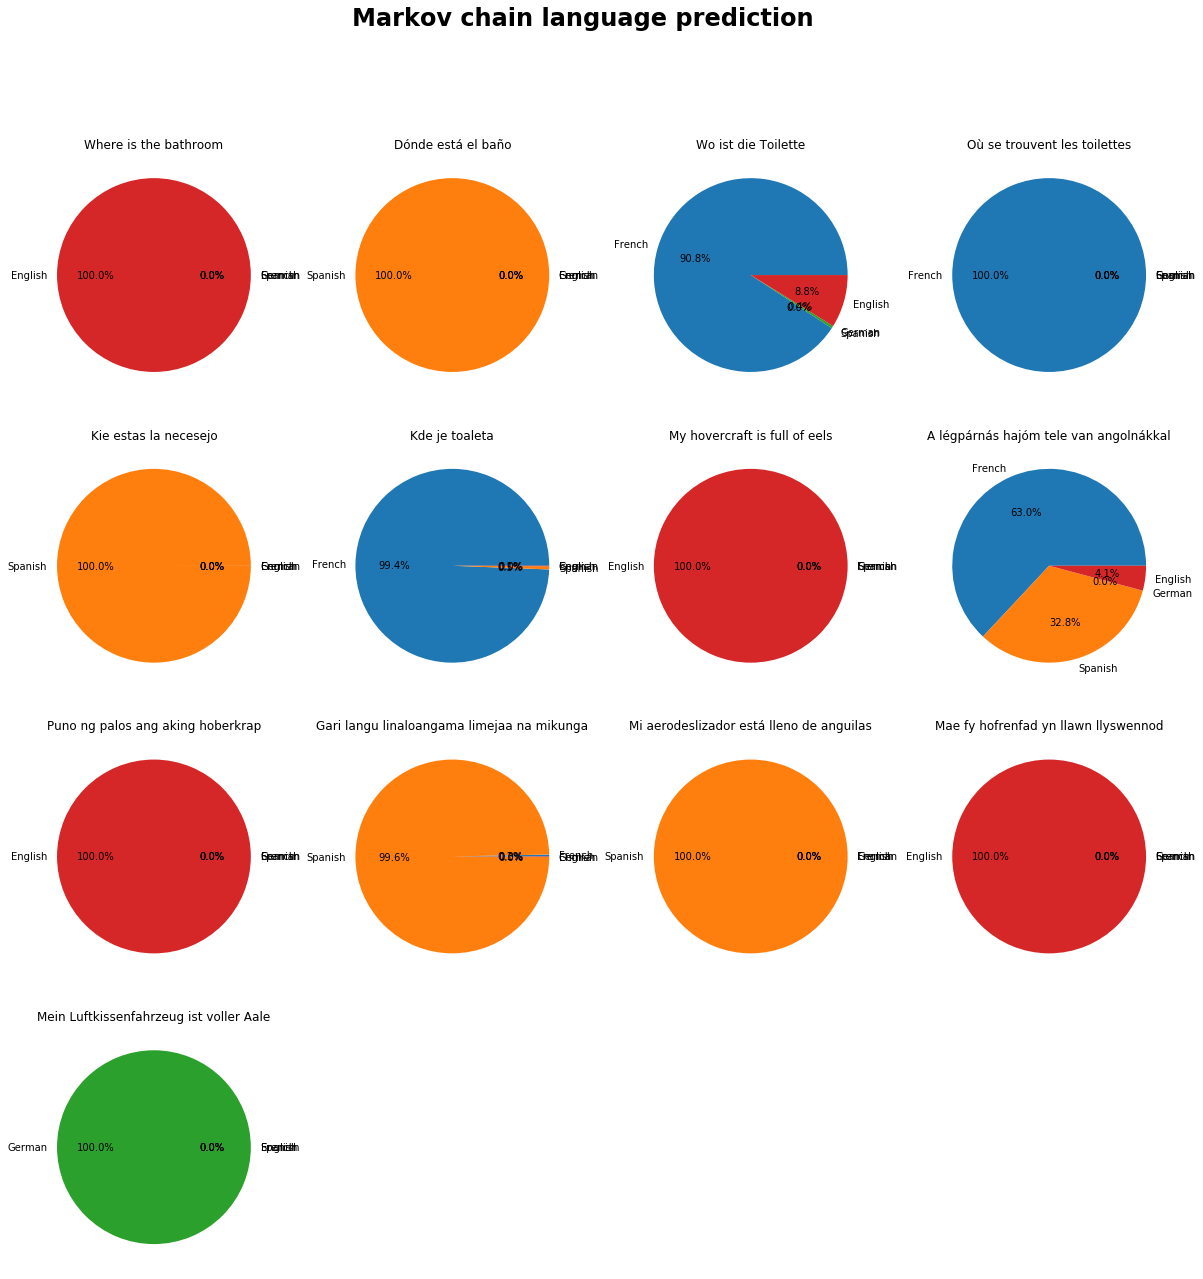

In [12]:
from matplotlib.gridspec import GridSpec
fig = plt.gcf()
plt.suptitle("Markov chain language prediction", fontsize=24, fontweight='bold')
fig.set_size_inches(20.5,20.5)
the_grid = GridSpec(len(t)//4 + 1, 4)
count = 0
for phrase in t:
    probs = language_probs(phrase, models)
    plt.subplot(the_grid[count // 4 , count % 4], aspect=1)
    plt.pie(list(probs.values()), autopct='%1.1f%%', labels=list(probs.keys()))
    plt.title(phrase)
    count += 1


# Pattern Uncovering (Lab 8)

In [171]:
class HMM:
    
    
    def __init__(self, num_states):
        self.NUM_STATES = num_states
        self.START = 0
        self.END = num_states + 1
        
        self.states = list(range(self.END + 1))
        self.outputs = list(string.ascii_lowercase + " ")
        
        self.create()
        
        
    def create(self):
        # transition probability matrix
        self.a = {}
        
        # output probabilities
        self.e = {}
        
        # create the starting transition dictionary
        self.a[self.START] = {}  

        # set probability transitions out of START for each internal state
        for i in range(1, self.END):
            self.a[self.START][i] = init_val()
        normalize(self.a[self.START])

        for i in range(1, self.END):
            
            # create the internal transition dictionary
            self.a[i] = {}
            
            # set probability transitions out of this state to each other state and the END
            for j in range(1, self.END + 1):
                self.a[i][j] = init_val()
            normalize(self.a[i])
              
            # create observation dictionary
            self.e[i] = {}
            
            # set random observation probabilities
            for c in self.outputs:
                self.e[i][c] = init_val()
            normalize(self.e[i])
                
                
    def forward(self, sequence):
        f = np.zeros((len(self.states), len(sequence)))
        #print(f, len(self.states), len(sequence))
        
        #############
        # WRITE FORWARD ALGORITHM HERE
        # Assume sequence always begins with " "
        # So that index one of the matrix is also the first letter of the word
        #############
        
        #initialize start as 1
        f[self.START][0] = 1
        for t in range(1, len(sequence)): #each time step
            #for each state
            for s in range(1, len(self.states) - 1):
                probs = []
                
                #This is for 
                for s1 in range(len(self.states)-1):
                    #print(self.a[s][s1])
                    probs.append(self.a[s1][s] *  self.e[s][sequence[t]] * f[s1][t-1])
                f[s][t] = sum(probs)
                
            probs = []
            for s2 in range(1, len(self.states) - 1):

                
                probs.append(self.a[s2][self.END] * f[s2][t])
                
            f[self.END][t] = sum(probs)
        return f
    
    
    def probability(self, sequence):
        f = self.forward(sequence)
        return f[self.END][len(sequence) - 1]
                
        
    def backward(self, sequence):
        b = np.zeros((len(self.states), len(sequence)))
        b[self.END][len(sequence) - 1] = 1
        for s in range(1, self.END):
            b[s][len(sequence) - 1] = self.a[s][self.END]

        for i in range(len(sequence) - 2, -1, -1):
            for k in range(0, self.END):
                for m in range(1, self.END):
                    b[k][i] += self.e[m][sequence[i + 1]] * b[m][i + 1] * self.a[k][m]
        return b
       
        
    def viterbi(self, sequence):
        # Record the max of probability calculations here
        v = np.zeros((len(self.states), len(sequence)))
        
        # Record the backpointers here
        vp = np.zeros((len(self.states), len(sequence)))

        #############
        # WRITE VITERBI ALGORITHM HERE
        # Assume sequence always begins with " "
        ############# 
        v[self.START][0] = 1
        for t in range(1, len(sequence)):
            for s in range(1, len(self.states) - 1):
                probs = []
                for s1 in range(len(self.states) - 1):
                    probs.append(self.a[s1][s] *  self.e[s][sequence[t]] * v[s1][t-1])
                v[s][t] = max(probs)
                vp[s][t] = probs.index(max(probs))
                
            for s2 in range(1, len(self.states) - 1):
                probs.append(self.a[s2][self.END] * v[s2][t])
                
            v[self.END][t] = max(probs)
            vp[self.END][t] = probs.index(max(probs))
                
        
        return v, vp
    
    
    def most_likely_path(self, sequence):
        v, vp = self.viterbi(sequence)
        
        s = vp[self.END][len(sequence) - 1]
        path = str(int(s))
        t = len(sequence) - 1
        while t != 0:
            s = vp[int(s)][t]
            path = str(int(s)) + path
            t -= 1
            
        return path
            
        
    def load_data(self, filename):
        lines = []
        fin = open(filename)
        
        for line in fin.readlines()[:200]:
            p = " "
            for c in line.lower():
                if c in self.outputs:
                    p += c
                    
            if len(p) > 1:
                lines.append(p)

        fin.close()
        
        return lines
    
    
    def train(self, filename, iterations):
        
        # Open file for training
        lines = self.load_data(filename)
        
        for it in range(iterations):
            logprob = 0

            # initialize new probability matrices with pseduocounts
            eup = {}
            for s in range(1, self.END):
                eup[s] = {}
                for o in self.outputs:
                    eup[s][o] = 1

            aup = {}
            aup[self.START] = {}
            for i in range(1, self.END):
                aup[self.START][i] = 1
                aup[i] = {}
                for j in range(1, self.END + 1):
                    aup[i][j] = 1

            # train for each line
            for p in lines:

                # forward alg
                f = self.forward(p) 
                
                # backward alg
                b = self.backward(p)
                
                logprob += np.log(b[0][0])

                # gather probabilistic counts
                for k in range(1, self.END):
                    for i in range(len(p)):
                        eup[k][p[i]] += f[k][i] * b[k][i] / b[0][0]
                        if i != len(p) - 1:
                            for m in range(1, self.END):
                                aup[k][m] += f[k][i] * self.a[k][m] * self.e[m][p[i + 1]] * b[m][i + 1] / b[0][0]
                for m in range(1, self.END):
                    aup[0][m] += f[0][0] * self.a[0][m] * self.e[m][p[1]] * b[m][1] / b[0][0]
                    aup[m][self.END] += f[m][len(p) - 1] * self.a[m][self.END] * b[m][len(p) - 1] / b[0][0]

            # normalize
            for s in eup:
                normalize(eup[s])
            for s in aup:
                normalize(aup[s])

            # update the transition and observation probabilities
            self.e = eup
            self.a = aup
            print(logprob)   
        
        
    def draw(self, title, size, data):
        from matplotlib.gridspec import GridSpec
        fig = plt.gcf()
        plt.suptitle(title, fontsize=24, fontweight='bold')
        fig.set_size_inches(20.5,7.5)
        the_grid = GridSpec(1, size)
        for i in range(1, size):

            probs = {}            
            for d in data[i]:
                if data[i][d] >= 0.001:
                    probs[d] = data[i][d]                
            normalize(probs)

            plt.subplot(the_grid[0 , i - 1], aspect=1)
            plt.pie(list(probs.values()), autopct='%1.1f%%', labels=list(probs.keys()))
            plt.title(str(i))
            #print probs
            #count += 1
        
        
    def draw_outputs(self):
        self.draw("HMM Letter States", self.END, self.e)

            
    def draw_states(self):
        self.draw("HMM Hidden States", self.END, self.a)

In [188]:
h = HMM(3)
h.create()

#alice and wonderland
h.train("Books/wonderland.txt", 120)

-36626.48572420764
-29520.058618638654
-29895.854478443856
-29929.26094317622
-29929.833263887132
-29929.77666482721
-29929.70053289779
-29929.612250567137
-29929.50879651139
-29929.386699608334
-29929.242160130096
-29929.071030251092
-29928.868821574342
-29928.630747483734
-29928.351804574282
-29928.026894542578
-29927.650982730836
-29927.219281886708
-29926.727440143728
-29926.171702062074
-29925.54900283727
-29924.85695085059
-29924.093654499397
-29923.2573562316
-29922.345848352874
-29921.35565769015
-29920.280994087516
-29919.11245469218
-29917.835455702465
-29916.428319095285
-29914.859865225106
-29913.086238474927
-29911.046494530587
-29908.656151276344
-29905.797352017493
-29902.303329640996
-29897.93316905104
-29892.32986642994
-29884.949390695732
-29874.93935644418
-29860.931539033423
-29840.69526125253
-29810.602219720866
-29764.980847369818
-29696.004651121366
-29596.230331219514
-29466.94377940799
-29328.36219788058
-29212.051337118923
-29133.53443363978
-29084.43831839128

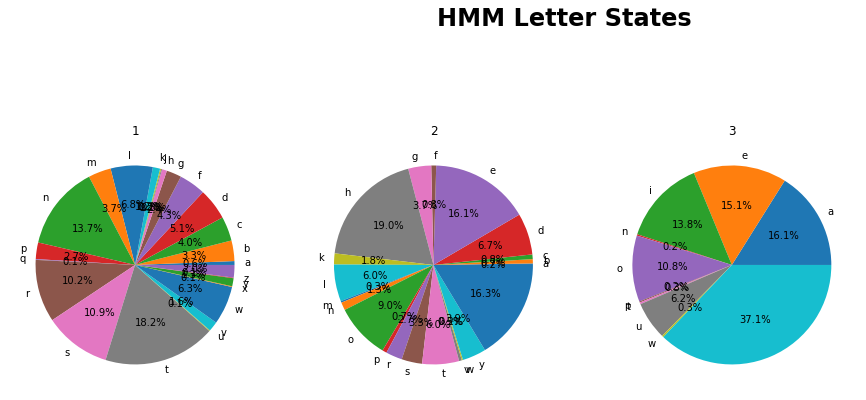

In [189]:
h.draw_outputs()

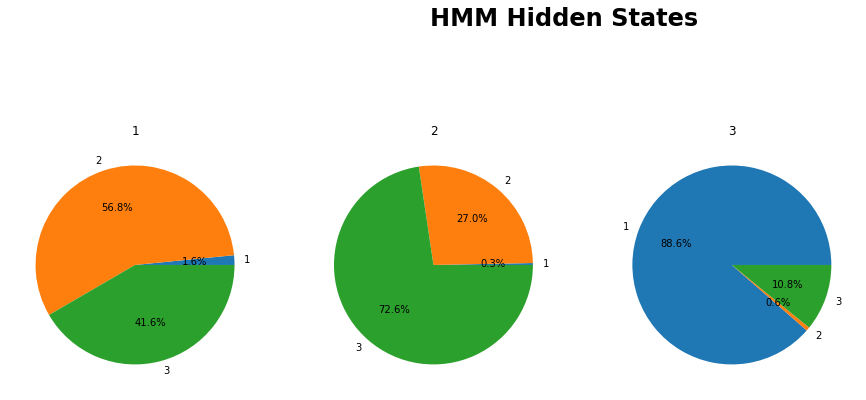

In [190]:
h.draw_states()

State three has a very high occurance of vowels in it. And the most common transition from state three is to state one, which has a majority of consonants in it. This makes sense as most words in the english language which have consonants have vowels that follow them. This is evident in the probability of emissions and transitions. At the same time consonants can often follow other consonants, this is also evident in the first state transition of one to two. Once at two however, most are followed by a vowel which is why the highest percentatge is to state three after two. And two then loops back to state one. 

In [179]:
h.probability(" one does not simply walk into mordor")

3.177800283216959e-48

In [180]:
h.most_likely_path(" one does not simply walk into mordor")

'0132132232323232321323213211321321322'

In [181]:
phrases = [" one does not simply walk into mordor", 
" stop trying to make fetch happen its not going to happen",
" has anyone really been far even as decided to use even go want to do look more like"]

In [185]:
for p in phrases:
    print("Phrase: ", p)
    print("Probability: ", h.probability(p))
    print("Path: ", h.most_likely_path(p))

Phrase:   one does not simply walk into mordor
Probability:  3.177800283216959e-48
Path:  0132132232323232321323213211321321322
Phrase:   stop trying to make fetch happen its not going to happen
Probability:  1.0956340107803026e-69
Path:  013232113213232132321321132321321321323232321132321321322
Phrase:   has anyone really been far even as decided to use even go want to do look more like
Probability:  1.1397510949681935e-98
Path:  032321132321321132132211321323232132323232323211323232113213213232132132132323213211
